LSTM

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [30]:
features = np.load('entire_utci_arrays(30-7)/data_features.npy')  # (1924, 30)
targets = np.load('entire_utci_arrays(30-7)/data_targets.npy')    # (1924, 7)
years = np.load('entire_utci_arrays(30-7)/years.npy')             # (1924,)

In [26]:
# features = np.load('entire_utci_arrays(30-7)/data_features.npy')
# targets = np.load('entire_utci_arrays(30-7)/data_targets.npy')

# print("Features shape:", features.shape)
# print("Targets shape:", targets.shape)

In [31]:
train_indices = (years <= 2017)
val_indices = (years >= 2018) & (years <= 2021)
test_indices = (years >= 2022)

X_train_raw, y_train_raw = features[train_indices], targets[train_indices]
X_val_raw, y_val_raw = features[val_indices], targets[val_indices]
X_test_raw, y_test_raw = features[test_indices], targets[test_indices]

In [32]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


X_train = scaler_X.fit_transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

# 3D tensor: (samples, timesteps, features
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


print("\nData split sizes:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Data split sizes:
Training set: 1540 samples
Validation set: 220 samples
Test set: 164 samples


In [34]:
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1])  
])

In [35]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 30, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,279 (462.03 KB)

 Trainable params: 118,279 (462.03 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.2850 - mae: 0.4594 - val_loss: 0.0365 - val_mae: 0.1619 - learning_rate: 0.0010
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0935 - mae: 0.2447 - val_loss: 0.0259 - val_mae: 0.1290 - learning_rate: 0.0010
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0714 - mae: 0.2129 - val_loss: 0.0235 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0557 - mae: 0.1881 - val_loss: 0.0214 - val_mae: 0.1137 - learning_rate: 0.0010
Epoch 5/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0460 - mae: 0.1721 - val_loss: 0.0181 - val_mae: 0.1002 - learning_rate: 0.0010
Epoch 6/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0404 - mae: 0.1598 - val_loss: 0.0173 - val_mae: 0.0958 - learning_rate: 0.0010
Epoch 7/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0386 - mae: 0.1566 - val_loss: 0.0189 - val_mae: 0.1038 - learning_rate: 0.0010
Epoch

In [38]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Evaluating model...
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0137 - mae: 0.0884
Test Loss: 0.0151, Test MAE: 0.0946


In [39]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Evaluating model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0131 - mae: 0.0848
Test Loss: 0.0167, Test MAE: 0.0923


In [40]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


Evaluating model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0142 - mae: 0.0925 
Test Loss: 0.0131, Test MAE: 0.0903


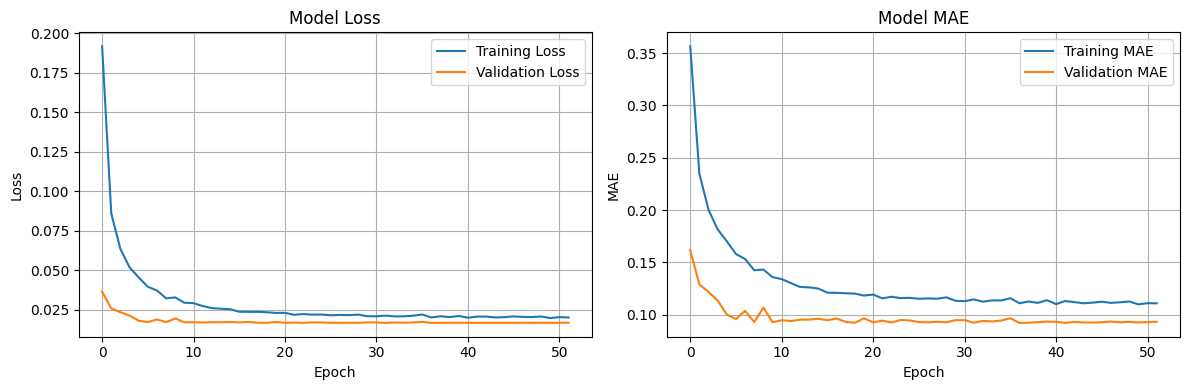

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
def evaluate_set(X, y, set_name):
    predictions = model.predict(X)
    
    # pred_original = target_scaler.inverse_transform(predictions)
    pred_scaled=predictions
    # y_original = target_scaler.inverse_transform(y)
    y_scaled=y
    
    # mse = np.mean((pred_original - y_original) ** 2)
    mse = np.mean((pred_scaled - y_scaled) ** 2)
    rmse = np.sqrt(mse)
    # mae = np.mean(np.abs(pred_original - y_original))
    mae = np.mean(np.abs(pred_scaled - y_scaled))
    
    print(f"\n{set_name} Set Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    return pred_scaled, y_scaled

train_pred, train_true = evaluate_set(X_train, y_train, "Training")
val_pred, val_true = evaluate_set(X_val, y_val, "Validation")
test_pred, test_true = evaluate_set(X_test, y_test, "Test")

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

Training Set Metrics:
MSE: 0.02
RMSE: 0.12
MAE: 0.09
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Validation Set Metrics:
MSE: 0.02
RMSE: 0.13
MAE: 0.09
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Test Set Metrics:
MSE: 0.01
RMSE: 0.11
MAE: 0.09


In [43]:
y_pred_test_rescaled = scaler_y.inverse_transform(test_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

In [44]:
num_samples_to_plot = 50  # Adjust based on your preference
y_pred_subset = y_pred_test_rescaled[:num_samples_to_plot, :]
y_actual_subset = y_test_rescaled[:num_samples_to_plot, :]

In [50]:
df=pd.DataFrame(y_pred_subset)
df.head()

,0,1,2,3,4,5,6
0,32.717884,32.417778,32.453728,32.481171,32.384186,32.349903,32.263031
1,31.914484,31.838179,31.822626,31.838774,31.814358,31.831322,31.741829
2,30.781446,31.031738,30.943691,30.937031,31.020697,31.111074,31.028244
3,29.960987,30.459902,30.321535,30.289421,30.457670,30.598524,30.532967
4,29.862097,30.410637,30.271542,30.218342,30.408615,30.551662,30.507952


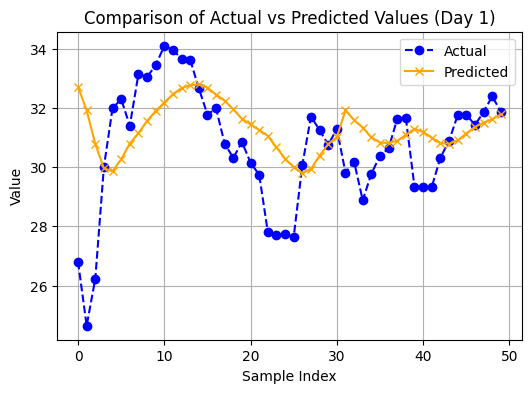

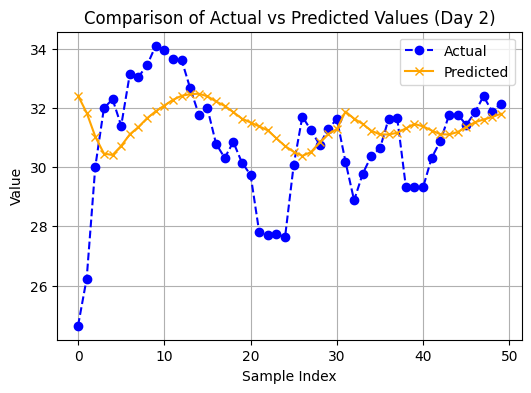

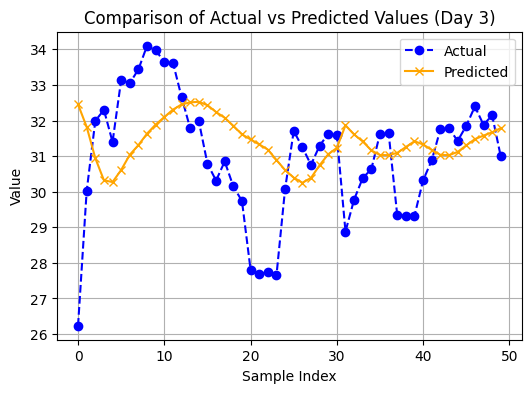

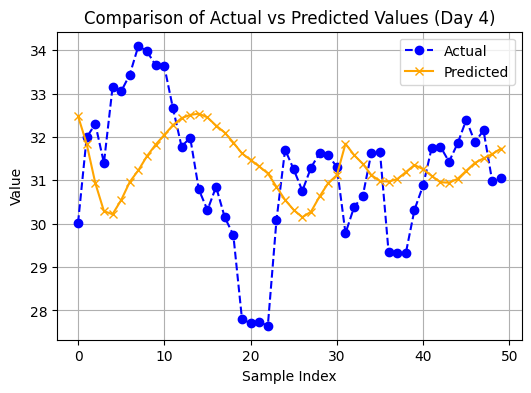

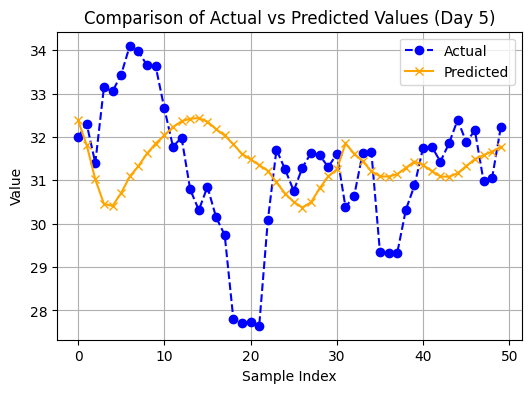

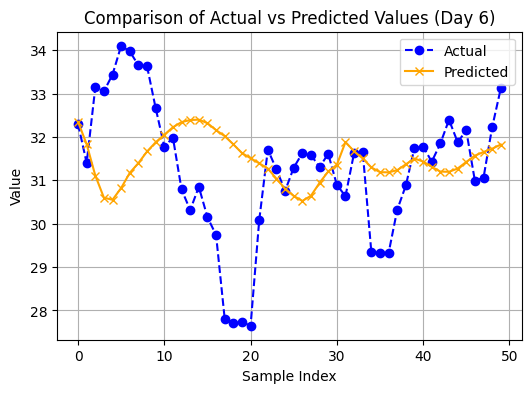

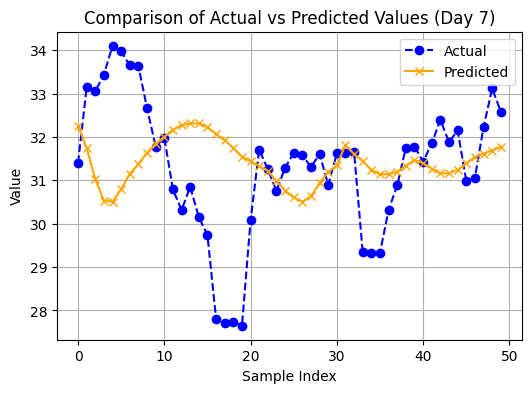

In [45]:
for i in range(y_pred_subset.shape[1]):  # Iterate over timesteps (or features)
    plt.figure(figsize=(6, 4))
    plt.plot(y_actual_subset[:, i], label='Actual', marker='o', linestyle='--', color='blue')
    plt.plot(y_pred_subset[:, i], label='Predicted', marker='x', linestyle='-', color='orange')
    plt.title(f"Comparison of Actual vs Predicted Values (Day {i + 1})")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


In [51]:
errors = y_test_rescaled - y_pred_test_rescaled
mae_per_timestep = np.mean(np.abs(errors), axis=0)
print("Mean Absolute Error (MAE) per timestep:", mae_per_timestep)

Mean Absolute Error (MAE) per timestep: [1.14753178 1.27763456 1.30448368 1.34168064 1.36403882 1.39777425
 1.45472948]


LSTM+TRANSFORMER

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [53]:
def build_lstm_transformer_model(input_shape, output_dim):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # LSTM Layer for sequential processing
    lstm_out = layers.LSTM(256, activation='tanh', return_sequences=True)(inputs)
    lstm_out = layers.Dropout(0.3)(lstm_out)
    
    # Transformer Layer for attention-based modeling
    transformer_out = layers.MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
    transformer_out = layers.Dropout(0.3)(transformer_out)
    transformer_out = layers.LayerNormalization()(transformer_out)
    
    # Flatten the output from Transformer to feed into Dense layers
    transformer_out = layers.GlobalAveragePooling1D()(transformer_out)
    
    # Dense Layer for regression output
    dense_out = layers.Dense(128, activation='relu')(transformer_out)
    dense_out = layers.Dropout(0.3)(dense_out)
    
    # Output layer (target dimensions)
    outputs = layers.Dense(output_dim)(dense_out)

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


In [54]:
input_shape = (30, 1)  # 30 past days with 1 feature
output_dim = 7         # Predicting 7 future days 


In [55]:
model = build_lstm_transformer_model(input_shape, output_dim)
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)   │ (None, 30, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_22 (LSTM)                │ (None, 30, 256)           │         264,192 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_33 (Dropout)          │ (None, 30, 256)           │               0 │ lstm_22[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 30, 256)           │         263,168 │ dropout_33[0][0],          │
│ (MultiHeadAttention)          │                           │                 │ dropout_33[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_35 (Dropout)          │ (None, 30, 256)           │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 30, 256)           │             512 │ dropout_35[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 256)               │               0 │ layer_normalization[0][0]  │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 128)               │          32,896 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_36 (Dropout)          │ (None, 128)               │               0 │ dense_22[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 7)                 │             903 │ dropout_36[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 561,671 (2.14 MB)

 Trainable params: 561,671 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [57]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.1284 - mae: 0.2672 - val_loss: 0.0195 - val_mae: 0.1008 - learning_rate: 0.0010
Epoch 2/500
50/97 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0484 - mae: 0.1753  

KeyboardInterrupt: 

In [ ]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

In [ ]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

In [ ]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_set(X, y, set_name):
    predictions = model.predict(X)
    
    # pred_original = target_scaler.inverse_transform(predictions)
    pred_scaled=predictions
    # y_original = target_scaler.inverse_transform(y)
    y_scaled=y
    
    # mse = np.mean((pred_original - y_original) ** 2)
    mse = np.mean((pred_scaled - y_scaled) ** 2)
    rmse = np.sqrt(mse)
    # mae = np.mean(np.abs(pred_original - y_original))
    mae = np.mean(np.abs(pred_scaled - y_scaled))
    # r2 = r2_score(y_scaled, pred_scaled)
    
    print(f"\n{set_name} Set Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    # print(f"R2: {r2:.2f}")

    
    return pred_scaled, y_scaled

train_pred, train_true = evaluate_set(X_train, y_train, "Training")
val_pred, val_true = evaluate_set(X_val, y_val, "Validation")
test_pred, test_true = evaluate_set(X_test, y_test, "Test")

In [ ]:
num_samples_to_plot = 50  # Adjust based on your preference
y_pred_subset = test_pred[:num_samples_to_plot, :]
y_actual_subset = y_test[:num_samples_to_plot, :]

In [ ]:
for i in range(y_pred_subset.shape[1]):  # Iterate over timesteps (or features)
    plt.figure(figsize=(6, 4))
    plt.plot(y_actual_subset[:, i], label='Actual', marker='o', linestyle='--', color='blue')
    plt.plot(y_pred_subset[:, i], label='Predicted', marker='x', linestyle='-', color='orange')
    plt.title(f"Comparison of Actual vs Predicted Values (Day {i + 1})")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
errors = y_test - test_pred
mae_per_timestep = np.mean(np.abs(errors), axis=0)
print("Mean Absolute Error (MAE) per timestep:", mae_per_timestep)

GRU

In [59]:
from tensorflow.keras.layers import GRU, Dropout, Dense

In [61]:
model_gru = Sequential([
    GRU(256, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(128, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1])  # Output layer with 7 units for predicting 7 days
])

In [62]:
optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model_gru.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 30, 256)             │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [64]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/500
21/49 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.0403 - mae: 0.1597 

KeyboardInterrupt: 

In [ ]:
print("\nEvaluating model...")
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


GRU+TRANSFORMER